In [2]:
%%time
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import stats
import subprocess
from pathlib import Path
import csv
import pyproj
from shapely.ops import transform
from functools import partial
import pickle
import numpy as np
from io import StringIO
from shapely.geometry import Point, Polygon
import datetime
import os
import sys

module_path = sys.path.append('C:/Users/emman/Documents/git/UrbanDisplacementStudio2020/Sydney/scripts')
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path
from clean_tweets import  convert_shapefile_crs, find_frequencies


Wall time: 0 ns


In [96]:
def summary_stats(data):
    """
    Analyze the following:
        - Number of tweets (printed output)
        - Number of unique users (printed output)
        - Median number of tweets/user (returned output)
        - Number of tweets/user at the 99th percentile (returned output)    
        
    Parameters
    ----------
    data : pd.DataFrame or gpd.GeoDataFrame
        DataFrame containing tweets; must contain column `u_id` for user id
        
    Returns
    -------
    median_tweets : int or float
        Median number of tweets/user
     
    pct_99_tweets : int or float
        99th percentile of tweets/user  
    """
    # Number of tweets
    print("{} total tweets".format(len(data)))
    
    # Number of unique users
    print("{} unique users\n".format(data['u_id'].nunique()))
    
    # Percentiles of tweets/user (median + 99th)
    pct_50_tweets, pct_99_tweets = data.groupby('u_id').size().quantile([.50, .99])
    print("Median number of tweets/user: {} tweets".format(pct_50_tweets))
    print("99th percentile of tweets/user: {} tweets".format(pct_99_tweets))
    
    return pct_50_tweets, pct_99_tweets

In [117]:
# This function was generated by a previous UDP team. I just took the function and amended it to fit the Australian 
#tract datasets. 

def assign_home_location(data, uid='u_id', SA2='SA2_5DIG16', date='date', hour='hour',
                         min_tweets=10, min_days=10, min_hours=8):
    """
    Assign a home location for Twitter users and their tweets based on following methodology:
    
    1. Consider tracts satisfying the following properties:
        - More than `min_tweets` tweets total
        - Sent from more than `min_days` different days
        - Sent from more than `min_hours` different hours of the day
    2. Of the remaining candidates, select the tract with the most tweets
    
    This function does not guarantee that all Twitter users/tweets will be assigned a home location.
    Some users will not have any tweets that meet the criteria defined above; this will result in a
    missing value (np.NaN) being assigned to the home tract for that user's tweets.
    
    
    Parameters
    ----------
    data : pd.DataFrame or gpd.geodataframe.GeoDataFrame
        DataFrame containing the following columns (variables passed into the function):
            - uid : Twitter user ID
            - sa2 : Tract identifier (e.g. tract ID, FIPS code)
            - date : Datetime object containing just the date 
                     (year, month, and day; not a full timestamp)
            - hour : Integer containing 24-hour-format hour of tweet
    
    uid, tract, date, hour : string (optional, default='u_id', 'OBJECTID', 'date', 'hour')
        Column names to extract from `data`; additional details under `data` parameter
    
    min_tweets : integer (optional, default=10)
        Minimum number of tweets required from a user at a valid tract
        
    min_days : integer (optional, default=10)
        Minimum number of unique days a user must tweet from a valid tract
    
    min_hours : integer (optional, default=8)
        Minimum number of unique hours a user must tweet from a valid tract
    
    
    Returns
    -------
    pd.Series of length data.shape[0], containing a home location for each tweet.
    Note that this function is not an inplace operation. 
    e.g. df['home_tract'] = assign_home_location(df)
    
    """
    # Note: groupby is done multiple times to save computation time
    home_locations = (
        data
        # More than min_tweets
        .groupby(['u_id', 'SA2_5DIG16']) #will need to edit this to a different code later
        .filter(lambda user_tract: len(user_tract) > min_tweets)
        
        # More than min_days
        .groupby(['u_id', 'SA2_5DIG16'])  #will need to edit this to a different code later
        .filter(lambda user_tract: user_tract[date].nunique() > min_days)
        
        # More than min_hours
        .groupby(['u_id', 'SA2_5DIG16'])  #will need to edit this to a different code later
        .filter(lambda user_tract: user_tract[hour].nunique() > min_hours)
        
        # Extract home location
        .groupby(['u_id', 'SA2_5DIG16'])  #will need to edit this to a different code later
        .size()
        .reset_index(name='count')
        .sort_values(by='count', ascending=False)
        .loc[:, ['u_id', 'SA2_5DIG16']]
        .groupby('u_id')
        .first()
        .loc[:, 'SA2_5DIG16']
    )
    
    return data[uid].map(home_locations.to_dict())

In [118]:
def geometrize_tweets(df):
    """
    Convert DataFrame of tweets into GeoDataFrames based on lat/lon coords.
    
    Parameters
    ----------
    data : pd.DataFrame
        Must contain columns 'lat' and 'lon' containing lat/lon coordinates
        
    Returns
    -------
    gpd.geodataframe.GeoDataFrame
    
    """
    # Create a shapely.geometry.Point for each tweet
    geometry = [Point(xy) for xy in zip(df['location.lon'], df['location.lat'])]
    crs = {'init':'epsg:4326'}
    
    # Convert to GeoDataFrame, where each tweet's geometry is assigned to the lat/lon coords
    return gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [119]:
def filter_and_home_assign(data, shapefile, lower, upper):
    """
    Find subset of data to analyze based on lower/upper bounds on tweets/user, 
    then add home locations.
    
    Parameters
    ----------
    data : pd.DataFrame or gpd.GeoDataFrame
        DataFrame containing tweets; must contain column `u_id` for user id
    
    shapefile : gpd.GeoDataFrame
        Shapefile for tracts in tweets location.
        Must be in WGS84 (epsg:4326) format (to align with tweet lat/lon).
    
    lower, upper : int or float
        Lower (inclusive) and upper (exclusive) bounds on tweets/user.
        
    Returns
    -------
    filtered : gpd.GeoDataFrame
        Collection of tweets filtered by lower/upper and with tweet geographies.
        Contains new columns:
            - 'timestamp' : pd.Timestamp for time of tweet published
            - 'date' : date (int) of tweet published
            - 'hour' : 24-hour (int) of tweet published
            - 'home' : name of home location codigo (some may be NaN)
            - 'is_home' : boolean indicating whether tweet was made at home
    """
    # Filter based on lower and upper bound on tweets/user
    filtered = data.groupby('u_id').filter(lambda group: (len(group) >= lower) & (len(group) < upper))
    
    # Geometrize tweets (inplace) based on lat/lon
    filtered = geometrize_tweets(filtered)
    
    # Spatial join with tracts
    filtered = gpd.sjoin(filtered, shapefile, how='left', op='intersects')
    
    # Add datetime
    filtered['timestamp'] = pd.to_datetime(filtered['created_at'] // 1000, unit='s')
    filtered['date'] = filtered['timestamp'].dt.date
    filtered['hour'] = filtered['timestamp'].dt.hour
    
    # Add home location
    filtered['home'] = assign_home_location(filtered, SA2='SA2_MAIN16')
    filtered['is_home'] = filtered['SA2_MAIN16'] == filtered['home']
    
    return filtered

In [3]:
#read in the twitter data in box
au_twitter = pd.read_csv('C:\\Users\\emman\\box\\Twitter data\\Asia\\Sydney\\sydney.csv')

In [4]:
au_twitter.dropna(inplace=True)

In [5]:
au_twitter.head()

,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209


In [6]:
au_twitter.shape

(6450144, 14)

Let's give those lat long a specific geometry as a point value for later geospatial plotting

In [7]:
# Create a shapely.geometry.Point for each tweet
geometry = [Point(xy) for xy in zip(au_twitter['location.lon'], au_twitter['location.lat'])]
crs = {'init' :'epsg:4326'}

In [8]:
# Convert to GeoDataFrame, where each tweet's geometry is assigned to the lat/lon coords
twt_gdf = gpd.GeoDataFrame(au_twitter, crs=crs, geometry=geometry)

In [9]:
print(twt_gdf.shape)
twt_gdf.head()

(6450144, 15)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,POINT (151.21962664 -33.8780691)
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,POINT (151.08905613 -33.86905872)
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,POINT (150.94787082 -33.79827494)
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,POINT (151.1780059 -33.80927427)
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,POINT (151.22299293 -33.91220949)


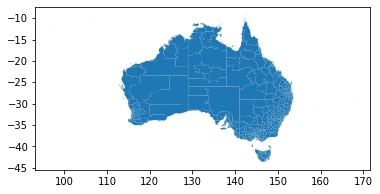

In [10]:
# Read Australia SA2 shapefiles
au_shape_sa2 = gpd.read_file('C:\\Users\\emman\\box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\SA2 Shapefiles\\SA2_2016_AUST.dbf')
# Crikey, our area is too big
au_shape_sa2.plot()
# We also need to change the crs 
au_shape_sa2.crs = {'init': 'epsg:4326'}

In [11]:
# have the shapefile only have areas that are in the state of New South Wales, and furthermore, in Greater Sydney
au_shape_sa2 = au_shape_sa2[au_shape_sa2.STE_NAME16 == 'New South Wales']
au_shape_sa2 = au_shape_sa2[au_shape_sa2.GCC_NAME16 == 'Greater Sydney']

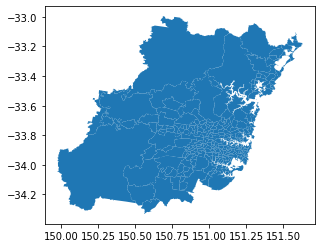

In [12]:
au_shape_sa2.plot()

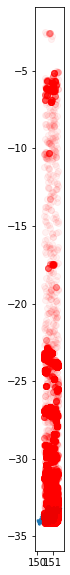

In [13]:
fig, ax = plt.subplots(figsize=(14, 10))
au_shape_sa2['geometry'].plot(ax=ax)
twt_gdf.plot(ax=ax, marker='o', color='red', alpha=0.05);

Hey, that's really stupid and uninformative. Maybe there's a better way?

In [14]:
au_shape_sa2.dropna(inplace=True)

In [15]:
twt_gdf.describe()

,id,created_at,u_id,u_created_at,u_followers_count,u_friends_count,location.lon,location.lat
count,6.450144e+06,6.450144e+06,6.450144e+06,6.450144e+06,6.450144e+06,6.450144e+06,6.450144e+06,6.450144e+06
mean,4.518478e+17,1.396564e+12,1.312918e+15,1.293151e+12,1.601158e+03,7.644436e+02,1.511114e+02,-3.374990e+01
std,1.360895e+17,3.244626e+10,3.163654e+16,5.404219e+10,2.031333e+04,2.502680e+03,1.538040e-01,9.638978e-01
min,2.253637e+17,1.342566e+12,7.180000e+02,1.152833e+12,-1.000000e+00,-1.000000e+00,1.504608e+02,-3.414781e+01
25%,3.460561e+17,1.371341e+12,4.727194e+07,1.245045e+12,1.270000e+02,1.590000e+02,1.510166e+02,-3.389651e+01
50%,4.384683e+17,1.393374e+12,2.152927e+08,1.289660e+12,3.230000e+02,3.490000e+02,1.511797e+02,-3.387157e+01
75%,5.468896e+17,1.419224e+12,4.996470e+08,1.329905e+12,8.930000e+02,8.080000e+02,1.512107e+02,-3.380846e+01
max,7.954513e+17,1.478485e+12,7.921684e+17,1.477703e+12,8.339538e+06,3.217600e+05,1.513516e+02,-2.500000e+00


In [16]:
twt_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6450144 entries, 0 to 7262132
Data columns (total 15 columns):
id                   int64
created_at           float64
text                 object
u_id                 int64
u_name               object
u_created_at         float64
u_description        object
u_followers_count    int64
type                 object
c_country            object
u_screen_name        object
u_friends_count      int64
location.lon         float64
location.lat         float64
geometry             object
dtypes: float64(4), int64(4), object(7)
memory usage: 787.4+ MB


In [17]:
twt_gdf['type'].value_counts()

ll     3429972
llp    3020172
Name: type, dtype: int64

In [18]:
twt_gdf.crs

{'init': 'epsg:4326'}

In [19]:
twt_gdf_sub = twt_gdf[500:1000]

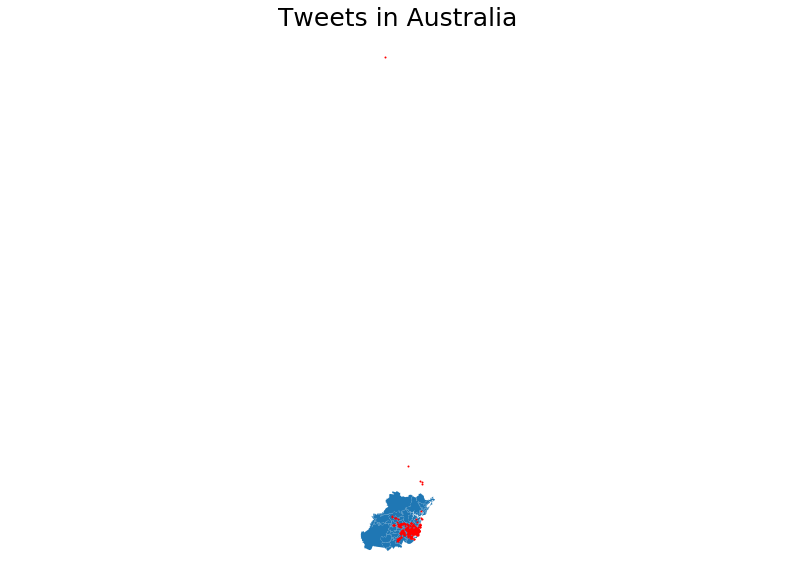

In [20]:
figure, ax = plt.subplots(figsize=(14,10))
base = au_shape_sa2.plot(ax=ax)
twt_gdf_sub.plot(ax=base, markersize=1, color="Red")
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('Tweets in Australia', fontdict= 
            {'fontsize':25})

plt.show()

This is still pretty stupid and uninformative, but at least it's a bit bigger! Maybe we can work on a spatial join so that we can get the tweets that fall just outside of Greater Sydney removed from our dataset

In [21]:
twtsa2_gdf = gpd.sjoin(twt_gdf,au_shape_sa2,how='left',op='within')

In [22]:
twtsa2_gdf.head()

,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry,index_right,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,POINT (151.21962664 -33.8780691),339.0,117031329,11329,Darlinghurst,11703,Sydney Inner City,117,Sydney - City and Inner South,1GSYD,Greater Sydney,1,New South Wales,0.8569
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,POINT (151.08905613 -33.86905872),413.0,120031575,11575,Strathfield,12003,Strathfield - Burwood - Ashfield,120,Sydney - Inner West,1GSYD,Greater Sydney,1,New South Wales,6.4515
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,POINT (150.94787082 -33.79827494),518.0,125041588,11588,Pendle Hill - Girraween,12504,Parramatta,125,Sydney - Parramatta,1GSYD,Greater Sydney,1,New South Wales,4.4615
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,POINT (151.1780059 -33.80927427),416.0,121011399,11399,Chatswood (West) - Lane Cove North,12101,Chatswood - Lane Cove,121,Sydney - North Sydney and Hornsby,1GSYD,Greater Sydney,1,New South Wales,5.5372
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,POINT (151.22299293 -33.91220949),360.0,118021564,11564,Kensington (NSW),11802,Eastern Suburbs - South,118,Sydney - Eastern Suburbs,1GSYD,Greater Sydney,1,New South Wales,2.6422


In [23]:
twtsa2_gdf = twtsa2_gdf[twtsa2_gdf.STE_NAME16=='New South Wales']

In [24]:
twtsa2_gdf.shape

(6178094, 28)

In [25]:
twtsa2_gdf = twtsa2_gdf[twtsa2_gdf.GCC_NAME16=='Greater Sydney']

In [26]:
twtsa2_gdf.shape

(6178094, 28)

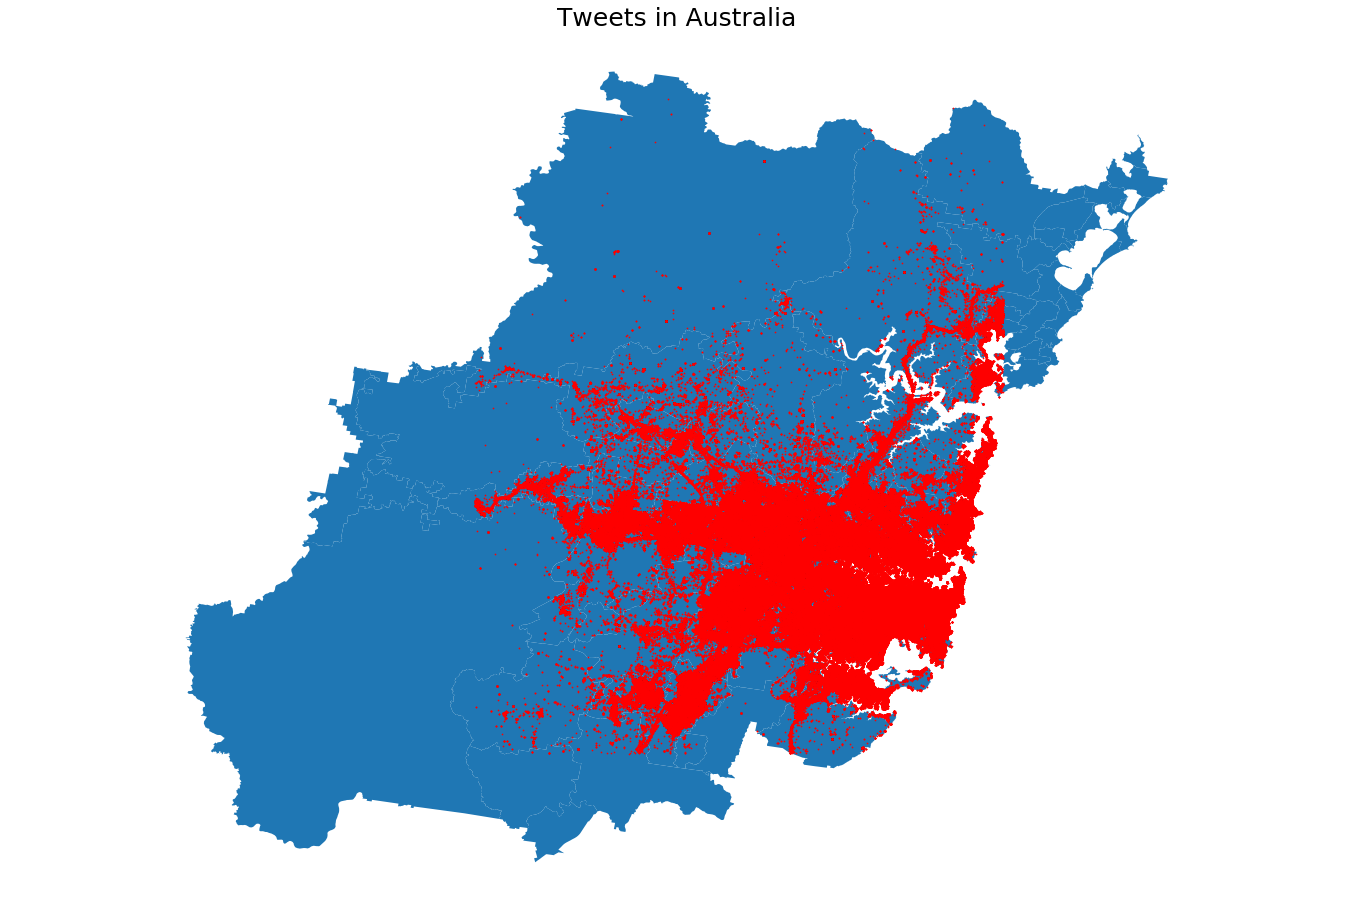

In [27]:
figure, ax = plt.subplots(figsize=(24,16))
base = au_shape_sa2.plot(ax=ax)
twtsa2_gdf.plot(ax=base, markersize=.5, color="Red")
lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('Tweets in Australia', fontdict= 
            {'fontsize':25})

plt.show()

In [28]:
# Select only users with greater than 20 tweets
df_20 = twtsa2_gdf.groupby('u_id').filter(lambda group: len(group) > 20)

print(df_20.shape)
df_20.head()

(5672392, 28)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry,index_right,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,POINT (151.21962664 -33.8780691),339.0,117031329,11329,Darlinghurst,11703,Sydney Inner City,117,Sydney - City and Inner South,1GSYD,Greater Sydney,1,New South Wales,0.8569
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,POINT (151.08905613 -33.86905872),413.0,120031575,11575,Strathfield,12003,Strathfield - Burwood - Ashfield,120,Sydney - Inner West,1GSYD,Greater Sydney,1,New South Wales,6.4515
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,POINT (150.94787082 -33.79827494),518.0,125041588,11588,Pendle Hill - Girraween,12504,Parramatta,125,Sydney - Parramatta,1GSYD,Greater Sydney,1,New South Wales,4.4615
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,POINT (151.1780059 -33.80927427),416.0,121011399,11399,Chatswood (West) - Lane Cove North,12101,Chatswood - Lane Cove,121,Sydney - North Sydney and Hornsby,1GSYD,Greater Sydney,1,New South Wales,5.5372
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,POINT (151.22299293 -33.91220949),360.0,118021564,11564,Kensington (NSW),11802,Eastern Suburbs - South,118,Sydney - Eastern Suburbs,1GSYD,Greater Sydney,1,New South Wales,2.6422


# Extract home location

## Ate's methodology for extracting home location:

1. Consider tracts satisfying the following properties:
 * More than 10 tweets total
 * Sent from more than 10 different days
 * Sent from more than 8 different hours of the day
2. Of the remaining candidates, select the tract with the most tweets



### 1a. More than 10 tweets total¶

Explanation of code below:

1. From our data
2. Group by user u_id and tract OBJECTID (assumed to be the tract ID)
3. Select only the user-tract combinations for which there are more than MIN_TWEETS tweets (i.e. for each user, select only the tracts with more than MIN_TWEETS tweets)

In [29]:
df_sample = df_20[:100000]

In [30]:
# This value should be adjusted when using the entire dataset
MIN_TWEETS = 2

output_1a = (
    df_sample # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: len(user_tract) > MIN_TWEETS) # (3)
)

In [31]:
print(output_1a.shape)
output_1a.head()

(81979, 28)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry,index_right,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,POINT (151.21962664 -33.8780691),339.0,117031329,11329,Darlinghurst,11703,Sydney Inner City,117,Sydney - City and Inner South,1GSYD,Greater Sydney,1,New South Wales,0.8569
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,POINT (150.94787082 -33.79827494),518.0,125041588,11588,Pendle Hill - Girraween,12504,Parramatta,125,Sydney - Parramatta,1GSYD,Greater Sydney,1,New South Wales,4.4615
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,POINT (151.1780059 -33.80927427),416.0,121011399,11399,Chatswood (West) - Lane Cove North,12101,Chatswood - Lane Cove,121,Sydney - North Sydney and Hornsby,1GSYD,Greater Sydney,1,New South Wales,5.5372
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,POINT (151.22299293 -33.91220949),360.0,118021564,11564,Kensington (NSW),11802,Eastern Suburbs - South,118,Sydney - Eastern Suburbs,1GSYD,Greater Sydney,1,New South Wales,2.6422
5,227394131700363265,1.343050e+12,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,42222507,Riastini Ratnasari,1.243177e+12,☮ I am an happilionaire ;DDDD\nAm blessed and ...,1008,ll,AUS,gektien,415,151.109044,-33.770251,POINT (151.10904395 -33.77025111),525.0,126021500,11500,Macquarie Park - Marsfield,12602,Ryde - Hunters Hill,126,Sydney - Ryde,1GSYD,Greater Sydney,1,New South Wales,10.6720


In [32]:
# Sanity check
# Check documentation for asserthttps://www.tutorialspoint.com/python/assertions_in_python.htm
assert all(output_1a.groupby(['u_id', 'SA2_5DIG16']).size() > MIN_TWEETS)

## 1b. Sent from more than 10 days

In [33]:
# First, some cleaning: extract timestamp from tweet data.
# Each tweet is recorded in UNIX time, and (for some reason) multiplied by 1000
output_1a['timestamp'] = pd.to_datetime(output_1a['created_at'] // 1000, unit='s')
output_1a['date'] = output_1a['timestamp'].dt.date

output_1a[['id', 'text', 'date','timestamp']].head()

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,id,text,date,timestamp
0,227410653344841728,@DaintyAintMe one hyphenated word for you my l...,2012-07-23,2012-07-23 14:31:39
2,227395554844483584,@heyfeebs nah it was at 2am... and hopefully n...,2012-07-23,2012-07-23 13:31:39
3,227397391727333376,@JUSECALO @AndreaSernaRCN si el apuntador dict...,2012-07-23,2012-07-23 13:38:57
4,227398082562768896,@nichteo1995 cause we didnt meet before I leav...,2012-07-23,2012-07-23 13:41:42
5,227394131700363265,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,2012-07-23,2012-07-23 13:26:00


Explanation of code below:

1. From our data
2. Group by user u_id and SA2 MAINCODE
3. Select user-SA2 combinations for which there are more than MIN_DAYS unique dates

In [34]:
# This value should be adjusted when using the full dataset
MIN_DAYS = 2

output_1b = (
    output_1a # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: user_tract['date'].nunique() > MIN_DAYS) # (3)
)

In [35]:
print(output_1b.shape)
output_1b.head()

(74411, 30)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry,index_right,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,timestamp,date
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,POINT (151.21962664 -33.8780691),339.0,117031329,11329,Darlinghurst,11703,Sydney Inner City,117,Sydney - City and Inner South,1GSYD,Greater Sydney,1,New South Wales,0.8569,2012-07-23 14:31:39,2012-07-23
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,POINT (150.94787082 -33.79827494),518.0,125041588,11588,Pendle Hill - Girraween,12504,Parramatta,125,Sydney - Parramatta,1GSYD,Greater Sydney,1,New South Wales,4.4615,2012-07-23 13:31:39,2012-07-23
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,POINT (151.1780059 -33.80927427),416.0,121011399,11399,Chatswood (West) - Lane Cove North,12101,Chatswood - Lane Cove,121,Sydney - North Sydney and Hornsby,1GSYD,Greater Sydney,1,New South Wales,5.5372,2012-07-23 13:38:57,2012-07-23
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,POINT (151.22299293 -33.91220949),360.0,118021564,11564,Kensington (NSW),11802,Eastern Suburbs - South,118,Sydney - Eastern Suburbs,1GSYD,Greater Sydney,1,New South Wales,2.6422,2012-07-23 13:41:42,2012-07-23
5,227394131700363265,1.343050e+12,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,42222507,Riastini Ratnasari,1.243177e+12,☮ I am an happilionaire ;DDDD\nAm blessed and ...,1008,ll,AUS,gektien,415,151.109044,-33.770251,POINT (151.10904395 -33.77025111),525.0,126021500,11500,Macquarie Park - Marsfield,12602,Ryde - Hunters Hill,126,Sydney - Ryde,1GSYD,Greater Sydney,1,New South Wales,10.6720,2012-07-23 13:26:00,2012-07-23


In [36]:
# Sanity check
assert all(output_1b.groupby(['u_id', 'SA2_5DIG16'])['date'].nunique() > MIN_DAYS)

### 1c. Sent from more than 8 different hours of the day

In [37]:
output_1b['hour'] = output_1b['timestamp'].dt.hour
output_1b[['id', 'text', 'hour']].head()

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,text,hour
0,227410653344841728,@DaintyAintMe one hyphenated word for you my l...,14
2,227395554844483584,@heyfeebs nah it was at 2am... and hopefully n...,13
3,227397391727333376,@JUSECALO @AndreaSernaRCN si el apuntador dict...,13
4,227398082562768896,@nichteo1995 cause we didnt meet before I leav...,13
5,227394131700363265,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,13


Explanation of code below:

1. From our data
2. Group by user u_id and SA2 MAINCODE
3. Select user-tract combinations for which there are more than MIN_HOURS unique hours

In [38]:
# This value should be adjusted when using the full dataset
MIN_HOURS = 4

output_1c = (
    output_1b # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: user_tract['hour'].nunique() > MIN_HOURS) # (3)
)

In [39]:
print(output_1c.shape)
output_1c.head()

(63758, 31)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry,index_right,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,timestamp,date,hour
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,POINT (151.21962664 -33.8780691),339.0,117031329,11329,Darlinghurst,11703,Sydney Inner City,117,Sydney - City and Inner South,1GSYD,Greater Sydney,1,New South Wales,0.8569,2012-07-23 14:31:39,2012-07-23,14
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,POINT (150.94787082 -33.79827494),518.0,125041588,11588,Pendle Hill - Girraween,12504,Parramatta,125,Sydney - Parramatta,1GSYD,Greater Sydney,1,New South Wales,4.4615,2012-07-23 13:31:39,2012-07-23,13
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,POINT (151.1780059 -33.80927427),416.0,121011399,11399,Chatswood (West) - Lane Cove North,12101,Chatswood - Lane Cove,121,Sydney - North Sydney and Hornsby,1GSYD,Greater Sydney,1,New South Wales,5.5372,2012-07-23 13:38:57,2012-07-23,13
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,POINT (151.22299293 -33.91220949),360.0,118021564,11564,Kensington (NSW),11802,Eastern Suburbs - South,118,Sydney - Eastern Suburbs,1GSYD,Greater Sydney,1,New South Wales,2.6422,2012-07-23 13:41:42,2012-07-23,13
5,227394131700363265,1.343050e+12,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,42222507,Riastini Ratnasari,1.243177e+12,☮ I am an happilionaire ;DDDD\nAm blessed and ...,1008,ll,AUS,gektien,415,151.109044,-33.770251,POINT (151.10904395 -33.77025111),525.0,126021500,11500,Macquarie Park - Marsfield,12602,Ryde - Hunters Hill,126,Sydney - Ryde,1GSYD,Greater Sydney,1,New South Wales,10.6720,2012-07-23 13:26:00,2012-07-23,13


In [40]:
# Sanity check
assert all(output_1c.groupby(['u_id', 'SA2_5DIG16'])['hour'].nunique() > MIN_HOURS)

## 2. Of the remaining candidates, select the tract with the most tweets

In [41]:
# View number of tweets per user per tract
output_1c.groupby(['u_id', 'SA2_5DIG16']).size()

u_id       SA2_5DIG16
7512       11422          13
           11423           8
10706      11326          14
           11336          12
           11337          16
36713      11326          16
628523     11337           8
638933     11500          22
643723     11340          11
657613     11337          35
           11416          17
715803     11326          14
755268     11419          20
771712     11332           5
807353     11337           8
           11341           9
           11394          14
815214     11336          14
           11414          13
866871     11337          10
870481     11337          14
1087481    11337           7
1657951    11337           8
           11501           8
1680891    11564          11
1816471    11408          10
1840681    11330          19
           11473          17
2170461    11337          12
2275821    11382          68
2298341    11337           6
2608101    11420          26
2762801    11423          13
2970871    11398     

It looks to be the case that there are some users that have more than one tract satisfying all three constraints specified in 1a-1c. Thus for all users, we select the most frequent tract.

Explanation of code below:

1. From our data
2. Group by user u_id and tract SA2_5DIG16
3. Find the number of observations in each user-tract combination
4. Name the resulting pd.Series count, then convert into a pd.DataFrame
5. At this point, we have a DataFrame with each row representing one user-tract combination. There are three variables: u_id, SA2_5DIG16, and count (which represents the number of tweets recorded at the user-tract combination). Sort the rows in descending order by count, so that the first row that a given u_id appears corresponds to the SA2_5DIG16 for which it has the most tweets.
6. Select the u_id and OBJECTID columns in preparation for grouping.
7. Group by u_id so that each group represents a user, and each observation inside the group is an OBJECTID. The ordering should still stay consistent with step 5, i.e. the first observation in each group corresponds to the OBJECTID at which the user tweeted the most.
8. Select that first observation, to result in the DataFrame shown below
9. Rename column for convenience
10. Convert into pd.Series for convenience

In [42]:
home_locations = (
    output_1c # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .size() # (3)
    .reset_index(name='count') # (4)
    .sort_values('count', ascending=False) # (5)
    .loc[:, ['u_id', 'SA2_5DIG16']] # (6)
    .groupby('u_id') # (7)
    .first() # (8)
    .rename(columns={'SA2_5DIG16':'home_sa2'}) # (9)
    .loc[:, 'home_sa2'] # (10)
)

In [43]:
# Sanity check: We should have one home location for each unique user in output_1c 
assert len(home_locations) == output_1c['u_id'].nunique()

In [44]:
# Assign each tweet a home_tract based on home_locations
# Using .map is orders of magnitudes faster than using a join
df_sample['home_sa2'] = df_sample['u_id'].map(home_locations.to_dict())

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
# Preprocessing necessary for function
df_sample['timestamp'] = pd.to_datetime(df_sample['created_at'] // 1000, unit='s')
df_sample['date'] = df_sample['timestamp'].dt.date
df_sample['hour'] = df_sample['timestamp'].dt.hour
df_sample['SA2_5DIG16'].astype(str,inplace=True)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

0         11329
1         11575
2         11588
3         11399
4         11564
5         11500
6         11363
7         11491
9         11431
11        11500
12        11514
13        11337
14        11497
15        11571
16        11459
17        11398
19        11337
22        11480
23        11480
24        11384
25        11514
27        11337
28        11571
29        11414
31        11300
32        11340
33        11607
35        11498
36        11325
37        11425
38        11394
39        11388
40        11394
41        11337
42        11500
43        11338
44        11335
45        11337
46        11337
47        11391
48        11419
49        11385
50        11340
51        11388
52        11334
53        11480
54        11340
55        11581
56        11484
57        11337
58        11578
59        11487
60        11337
64        11337
67        11473
68        11341
69        11337
71        11337
72        11300
73        11340
74        11420
75        11517
76      

In [47]:
df_sample['home_sa2'] = assign_home_location(df_sample, min_tweets=MIN_TWEETS, min_days=MIN_DAYS, min_hours=MIN_HOURS)
df_sample['home_sa2']

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0         11329
1         11334
2         11588
3         11399
4         11564
5         11500
6         11363
7         11491
9         11431
11        11500
12        11514
13        11329
14        11495
15        11571
16        11459
17        11337
19        11329
22        11480
23        11480
24        11384
25        11514
27        11329
28        11571
29        11414
31          NaN
32        11340
33        11607
35        11498
36        11337
37          NaN
38        11394
39        11332
40        11394
41        11337
42        11500
43        11337
44        11335
45        11350
46        11337
47          NaN
48        11429
49        11385
50        11340
51        11331
52        11334
53        11480
54        11340
55        11581
56        11484
57        11337
58          NaN
59        11505
60        11337
64        11329
67        11473
68        11341
69        11369
71        11337
72          NaN
73        11340
74        11420
75        11519
76      

In [48]:
df_sample['home_sa2'].isnull().sum()

19756

About 20% of our sample data is not assigned a home location; this is because that user's tweets were all filtered out in part 1a-1c. It remains to be seen how this proportion may change for the entire set of data (as opposed to the sample of 100,000 observations).

# Running the full dataset through home location code:

In [49]:
# This value should be adjusted when using the entire dataset
MIN_TWEETS = 2

output_1a = (
    twtsa2_gdf # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: len(user_tract) > MIN_TWEETS) # (3)
)

In [50]:
print(output_1a.shape)
output_1a.head()

(5660037, 28)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry,index_right,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,POINT (151.21962664 -33.8780691),339.0,117031329,11329,Darlinghurst,11703,Sydney Inner City,117,Sydney - City and Inner South,1GSYD,Greater Sydney,1,New South Wales,0.8569
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,POINT (151.08905613 -33.86905872),413.0,120031575,11575,Strathfield,12003,Strathfield - Burwood - Ashfield,120,Sydney - Inner West,1GSYD,Greater Sydney,1,New South Wales,6.4515
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,POINT (150.94787082 -33.79827494),518.0,125041588,11588,Pendle Hill - Girraween,12504,Parramatta,125,Sydney - Parramatta,1GSYD,Greater Sydney,1,New South Wales,4.4615
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,POINT (151.1780059 -33.80927427),416.0,121011399,11399,Chatswood (West) - Lane Cove North,12101,Chatswood - Lane Cove,121,Sydney - North Sydney and Hornsby,1GSYD,Greater Sydney,1,New South Wales,5.5372
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,POINT (151.22299293 -33.91220949),360.0,118021564,11564,Kensington (NSW),11802,Eastern Suburbs - South,118,Sydney - Eastern Suburbs,1GSYD,Greater Sydney,1,New South Wales,2.6422


In [51]:
# Sanity check
# Check documentation for asserthttps://www.tutorialspoint.com/python/assertions_in_python.htm
assert all(output_1a.groupby(['u_id', 'SA2_5DIG16']).size() > MIN_TWEETS)

In [52]:
# First, some cleaning: extract timestamp from tweet data.
# Each tweet is recorded in UNIX time, and (for some reason) multiplied by 1000
output_1a['timestamp'] = pd.to_datetime(output_1a['created_at'] // 1000, unit='s')
output_1a['date'] = output_1a['timestamp'].dt.date

output_1a[['id', 'text', 'date','timestamp']].head()

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,id,text,date,timestamp
0,227410653344841728,@DaintyAintMe one hyphenated word for you my l...,2012-07-23,2012-07-23 14:31:39
1,227395003947810817,Optus在strathfield附近的基站是不是出故障了，各种network lost...,2012-07-23,2012-07-23 13:29:28
2,227395554844483584,@heyfeebs nah it was at 2am... and hopefully n...,2012-07-23,2012-07-23 13:31:39
3,227397391727333376,@JUSECALO @AndreaSernaRCN si el apuntador dict...,2012-07-23,2012-07-23 13:38:57
4,227398082562768896,@nichteo1995 cause we didnt meet before I leav...,2012-07-23,2012-07-23 13:41:42


In [53]:
# This value should be adjusted when using the full dataset
MIN_DAYS = 2

output_1b = (
    output_1a # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: user_tract['date'].nunique() > MIN_DAYS) # (3)
)

In [54]:
print(output_1b.shape)
output_1b.head()

(5361600, 30)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry,index_right,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,timestamp,date
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,POINT (151.21962664 -33.8780691),339.0,117031329,11329,Darlinghurst,11703,Sydney Inner City,117,Sydney - City and Inner South,1GSYD,Greater Sydney,1,New South Wales,0.8569,2012-07-23 14:31:39,2012-07-23
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,POINT (150.94787082 -33.79827494),518.0,125041588,11588,Pendle Hill - Girraween,12504,Parramatta,125,Sydney - Parramatta,1GSYD,Greater Sydney,1,New South Wales,4.4615,2012-07-23 13:31:39,2012-07-23
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,POINT (151.1780059 -33.80927427),416.0,121011399,11399,Chatswood (West) - Lane Cove North,12101,Chatswood - Lane Cove,121,Sydney - North Sydney and Hornsby,1GSYD,Greater Sydney,1,New South Wales,5.5372,2012-07-23 13:38:57,2012-07-23
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,POINT (151.22299293 -33.91220949),360.0,118021564,11564,Kensington (NSW),11802,Eastern Suburbs - South,118,Sydney - Eastern Suburbs,1GSYD,Greater Sydney,1,New South Wales,2.6422,2012-07-23 13:41:42,2012-07-23
5,227394131700363265,1.343050e+12,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,42222507,Riastini Ratnasari,1.243177e+12,☮ I am an happilionaire ;DDDD\nAm blessed and ...,1008,ll,AUS,gektien,415,151.109044,-33.770251,POINT (151.10904395 -33.77025111),525.0,126021500,11500,Macquarie Park - Marsfield,12602,Ryde - Hunters Hill,126,Sydney - Ryde,1GSYD,Greater Sydney,1,New South Wales,10.6720,2012-07-23 13:26:00,2012-07-23


In [55]:
# Sanity check
assert all(output_1b.groupby(['u_id', 'SA2_5DIG16'])['date'].nunique() > MIN_DAYS)

In [56]:
output_1b['hour'] = output_1b['timestamp'].dt.hour
output_1b[['id', 'text', 'hour']].head()

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,text,hour
0,227410653344841728,@DaintyAintMe one hyphenated word for you my l...,14
2,227395554844483584,@heyfeebs nah it was at 2am... and hopefully n...,13
3,227397391727333376,@JUSECALO @AndreaSernaRCN si el apuntador dict...,13
4,227398082562768896,@nichteo1995 cause we didnt meet before I leav...,13
5,227394131700363265,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,13


In [57]:
# This value should be adjusted when using the full dataset
MIN_HOURS = 4

output_1c = (
    output_1b # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .filter(lambda user_tract: user_tract['hour'].nunique() > MIN_HOURS) # (3)
)

In [58]:
print(output_1c.shape)
output_1c.head()

(5031683, 31)


,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry,index_right,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,timestamp,date,hour
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,POINT (151.21962664 -33.8780691),339.0,117031329,11329,Darlinghurst,11703,Sydney Inner City,117,Sydney - City and Inner South,1GSYD,Greater Sydney,1,New South Wales,0.8569,2012-07-23 14:31:39,2012-07-23,14
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,POINT (150.94787082 -33.79827494),518.0,125041588,11588,Pendle Hill - Girraween,12504,Parramatta,125,Sydney - Parramatta,1GSYD,Greater Sydney,1,New South Wales,4.4615,2012-07-23 13:31:39,2012-07-23,13
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,POINT (151.1780059 -33.80927427),416.0,121011399,11399,Chatswood (West) - Lane Cove North,12101,Chatswood - Lane Cove,121,Sydney - North Sydney and Hornsby,1GSYD,Greater Sydney,1,New South Wales,5.5372,2012-07-23 13:38:57,2012-07-23,13
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,POINT (151.22299293 -33.91220949),360.0,118021564,11564,Kensington (NSW),11802,Eastern Suburbs - South,118,Sydney - Eastern Suburbs,1GSYD,Greater Sydney,1,New South Wales,2.6422,2012-07-23 13:41:42,2012-07-23,13
5,227394131700363265,1.343050e+12,Bsok bangun pagi lagi nganter adik lagi. Oh pl...,42222507,Riastini Ratnasari,1.243177e+12,☮ I am an happilionaire ;DDDD\nAm blessed and ...,1008,ll,AUS,gektien,415,151.109044,-33.770251,POINT (151.10904395 -33.77025111),525.0,126021500,11500,Macquarie Park - Marsfield,12602,Ryde - Hunters Hill,126,Sydney - Ryde,1GSYD,Greater Sydney,1,New South Wales,10.6720,2012-07-23 13:26:00,2012-07-23,13


In [59]:
# Sanity check
assert all(output_1c.groupby(['u_id', 'SA2_5DIG16'])['hour'].nunique() > MIN_HOURS)

In [60]:
# View number of tweets per user per tract
output_1c.groupby(['u_id', 'SA2_5DIG16']).size()

u_id                SA2_5DIG16
718                 11337            7
1952                11337           17
2624                11426            5
5177                11291           36
                    11302           18
                    11310           17
                    11332           13
                    11337           14
                    11384            8
                    11473            5
                    11492           12
                    11553           14
5301                11327           68
                    11329            9
                    11336           36
                    11337           27
                    11538           37
6880                11337           15
7512                11325           51
                    11332            9
                    11334           26
                    11335           31
                    11336           36
                    11337          194
                    11345        

In [61]:
home_locations = (
    output_1c # (1)
    .groupby(['u_id', 'SA2_5DIG16']) # (2)
    .size() # (3)
    .reset_index(name='count') # (4)
    .sort_values('count', ascending=False) # (5)
    .loc[:, ['u_id', 'SA2_5DIG16']] # (6)
    .groupby('u_id') # (7)
    .first() # (8)
    .rename(columns={'SA2_5DIG16':'home_sa2'}) # (9)
    .loc[:, 'home_sa2'] # (10)
)

In [62]:
# Sanity check: We should have one home location for each unique user in output_1c 
assert len(home_locations) == output_1c['u_id'].nunique()

In [63]:
# Assign each tweet a home_tract based on home_locations
# Using .map is orders of magnitudes faster than using a join
twtsa2_gdf['home_sa2'] = twtsa2_gdf['u_id'].map(home_locations.to_dict())

In [64]:
# Preprocessing necessary for function
twtsa2_gdf['timestamp'] = pd.to_datetime(twtsa2_gdf['created_at'] // 1000, unit='s')
twtsa2_gdf['date'] = twtsa2_gdf['timestamp'].dt.date
twtsa2_gdf['hour'] = twtsa2_gdf['timestamp'].dt.hour
twtsa2_gdf['SA2_5DIG16'].astype(str,inplace=True)

0          11329
1          11575
2          11588
3          11399
4          11564
5          11500
6          11363
7          11491
9          11431
10         11330
11         11500
12         11514
13         11337
14         11497
15         11571
16         11459
17         11398
19         11337
20         11580
21         11325
22         11480
23         11480
24         11384
25         11514
26         11529
27         11337
28         11571
29         11414
31         11300
32         11340
33         11607
34         11409
35         11498
36         11325
37         11425
38         11394
39         11388
40         11394
41         11337
42         11500
43         11338
44         11335
45         11337
46         11337
47         11391
48         11419
49         11385
50         11340
51         11388
52         11334
53         11480
54         11340
55         11581
56         11484
57         11337
58         11578
59         11487
60         11337
64         113

In [65]:
twtsa2_gdf['home_sa2'] = assign_home_location(twtsa2_gdf, min_tweets=MIN_TWEETS, min_days=MIN_DAYS, min_hours=MIN_HOURS)
twtsa2_gdf['home_sa2']

0          11316
1          11398
2          11588
3          11400
4          11564
5          11500
6          11363
7          11491
9          11431
10           NaN
11         11500
12         11514
13         11316
14         11495
15         11571
16         11459
17         11332
19         11316
20           NaN
21           NaN
22         11480
23         11480
24         11384
25         11514
26           NaN
27         11316
28         11571
29         11414
31         11332
32         11340
33         11607
34         11409
35         11498
36         11325
37         11426
38         11337
39         11332
40         11337
41         11337
42         11500
43         11337
44         11333
45         11350
46         11337
47           NaN
48         11419
49         11385
50         11340
51         11331
52         11337
53         11480
54         11340
55         11581
56         11484
57         11337
58         11030
59         11505
60         11337
64         113

In [66]:
twtsa2_gdf['home_sa2'].isnull().sum()

421266

In [ ]:
#twtsa2_gdf.to_file("au_twitter.geojson", driver='GeoJSON')

In [ ]:
#twtsa2_gdf.to_csv('au_twitter.csv')

In [68]:
twtsa2_gdf.head()

,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry,index_right,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,home_sa2,timestamp,date,hour
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,POINT (151.21962664 -33.8780691),339.0,117031329,11329,Darlinghurst,11703,Sydney Inner City,117,Sydney - City and Inner South,1GSYD,Greater Sydney,1,New South Wales,0.8569,11316,2012-07-23 14:31:39,2012-07-23,14
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,POINT (151.08905613 -33.86905872),413.0,120031575,11575,Strathfield,12003,Strathfield - Burwood - Ashfield,120,Sydney - Inner West,1GSYD,Greater Sydney,1,New South Wales,6.4515,11398,2012-07-23 13:29:28,2012-07-23,13
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,POINT (150.94787082 -33.79827494),518.0,125041588,11588,Pendle Hill - Girraween,12504,Parramatta,125,Sydney - Parramatta,1GSYD,Greater Sydney,1,New South Wales,4.4615,11588,2012-07-23 13:31:39,2012-07-23,13
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,POINT (151.1780059 -33.80927427),416.0,121011399,11399,Chatswood (West) - Lane Cove North,12101,Chatswood - Lane Cove,121,Sydney - North Sydney and Hornsby,1GSYD,Greater Sydney,1,New South Wales,5.5372,11400,2012-07-23 13:38:57,2012-07-23,13
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,POINT (151.22299293 -33.91220949),360.0,118021564,11564,Kensington (NSW),11802,Eastern Suburbs - South,118,Sydney - Eastern Suburbs,1GSYD,Greater Sydney,1,New South Wales,2.6422,11564,2012-07-23 13:41:42,2012-07-23,13


# Starting to work with the home location dataframe 
### Parsing out years

I want to pull apart a few separate years so that we can look at changes in tweeting behaviors as a time series. 

In [105]:
au_twitter['timestamp'] = pd.to_datetime(au_twitter['created_at'] // 1000, unit='s')
au_twitter['date'] = au_twitter['timestamp'].dt.date

In [106]:
au_twitter['date'] = pd.to_datetime(au_twitter.date)

In [107]:
au_twitter.date.describe()

count                 6450144
unique                   1410
top       2013-12-31 00:00:00
freq                    14170
first     2012-07-17 00:00:00
last      2016-11-07 00:00:00
Name: date, dtype: object

So we know that the first available year is 2012 and the last is 2016. 

In [109]:
autwt_2012 = au_twitter.loc[(au_twitter.date>='2012-01-23')&(au_twitter.date<'2013-01-01')]

In [110]:
autwt_2012.head()

,id,created_at,text,u_id,u_name,u_created_at,u_description,u_followers_count,type,c_country,u_screen_name,u_friends_count,location.lon,location.lat,geometry,timestamp,date
0,227410653344841728,1.343054e+12,@DaintyAintMe one hyphenated word for you my l...,421108959,jcaldwellau,1.322231e+12,• Lascivious • Serial Flirt • Daring • Music l...,3877,ll,AUS,JCaldwellAu,339,151.219627,-33.878069,POINT (151.21962664 -33.8780691),2012-07-23 14:31:39,2012-07-23
1,227395003947810817,1.343050e+12,Optus在strathfield附近的基站是不是出故障了，各种network lost...,22230298,McKay Wei ,1.235797e+12,I make things on the web. #SocialMediaEnthusia...,1023,ll,AUS,McKayWei,850,151.089056,-33.869059,POINT (151.08905613 -33.86905872),2012-07-23 13:29:28,2012-07-23
2,227395554844483584,1.343050e+12,@heyfeebs nah it was at 2am... and hopefully n...,26226128,Daniel Baluyot,1.237898e+12,"17 year old Filipino, I'm a Sydneysider. I'll ...",148,ll,AUS,jhimdaniel,152,150.947871,-33.798275,POINT (150.94787082 -33.79827494),2012-07-23 13:31:39,2012-07-23
3,227397391727333376,1.343051e+12,@JUSECALO @AndreaSernaRCN si el apuntador dict...,149103289,Menchita,1.275050e+12,"Colombiana 100% paisa. Amo el cine, la buena c...",16,ll,AUS,Guizmito,91,151.178006,-33.809274,POINT (151.1780059 -33.80927427),2012-07-23 13:38:57,2012-07-23
4,227398082562768896,1.343051e+12,@nichteo1995 cause we didnt meet before I leav...,464020712,Julia,1.326568e+12,Done trusting people.,69,ll,AUS,justjuliac,68,151.222993,-33.912209,POINT (151.22299293 -33.91220949),2012-07-23 13:41:42,2012-07-23


In [111]:
pct_50, pct_99 = summary_stats(autwt_2012)

720158 total tweets
25272 unique users

Median number of tweets/user: 5.0 tweets
99th percentile of tweets/user: 391.2900000000009 tweets


In [120]:
autwt_2012 = filter_and_home_assign(autwt_2012, au_shape_sa2, pct_50, pct_99)

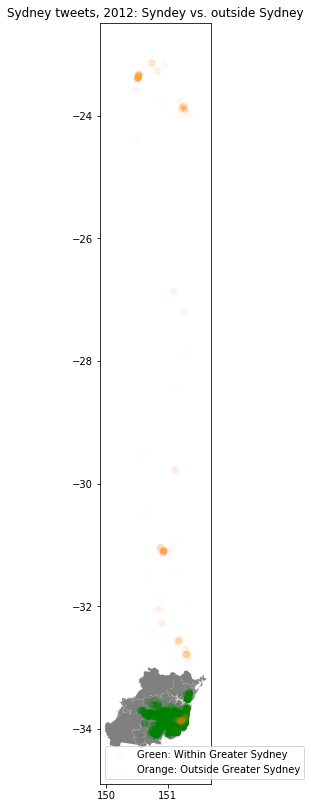

In [122]:
### Plot a 5% sample of 2015 tweets ###
# Green tweets: Joined to a SECU_CCNCT
# Orange tweets: No SECU_CCNCT assigned (NaN)
# Gray: Bogota shapefile

fig, ax = plt.subplots(figsize=(20, 14))
au_shape_sa2['geometry'].plot(ax=ax, color='gray')
sample = autwt_2012.sample(frac=0.05, random_state=42)
sample[~sample['SA2_5DIG16'].isnull()].plot(ax=ax, marker='o', color='green', alpha=0.01, label='Green: Within Greater Sydney')
sample[sample['SA2_5DIG16'].isnull()].plot(ax=ax, marker='o', color='orange', alpha=0.01, label='Orange: Outside Greater Sydney')
plt.legend()
plt.title('Sydney tweets, 2012: Syndey vs. outside Sydney');

From this, we see that we can use [~autwt_2012['SA2_5DIG16'].isnull()] as a filter to select just the tweets in Syndey, which is our area of interest. For all following analyses, we will restrict the population to just the tweets that fall inside Sydney depicted by the shapefile.

Our first summary statistic computes the ratio of tweets that have a home assignment.

In [124]:
num_home_assigned_tweets = (~autwt_2012.loc[~autwt_2012['SA2_5DIG16'].isnull(), 'home'].isnull()).sum()
n_tweets = len(autwt_2012[~autwt_2012['SA2_5DIG16'].isnull()])

print("{}/{} = {:.2%} of tweets have a home assignment.".format(
    num_home_assigned_tweets, n_tweets, num_home_assigned_tweets / n_tweets
))

276522/452503 = 61.11% of tweets have a home assignment.


Next, we are interested in the ratio of users that have a home assignment.

In [125]:
num_users_with_home = (~autwt_2012.loc[~autwt_2012['SA2_5DIG16'].isnull()].groupby('u_id')['home'].first().isnull()).sum()
n_users = len(autwt_2012[~autwt_2012['SA2_5DIG16'].isnull()].groupby('u_id'))

print("{}/{} = {:.2%} of users have a home assignment.".format(
    num_users_with_home, n_users, num_users_with_home / n_users
))

2598/12201 = 21.29% of users have a home assignment.


Lastly, we want to know the ratio of tweets that were made from home (i.e. SA2_5DIG16 and home are equal).

In [127]:
num_tweets_from_home = autwt_2012.loc[~autwt_2012['SA2_5DIG16'].isnull(), 'is_home'].sum()

print("{}/{} = {:.2%} of tweets are posted from the home tract.".format(
    num_tweets_from_home, n_tweets, num_tweets_from_home / n_tweets
))

0/452503 = 0.00% of tweets are posted from the home tract.


C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


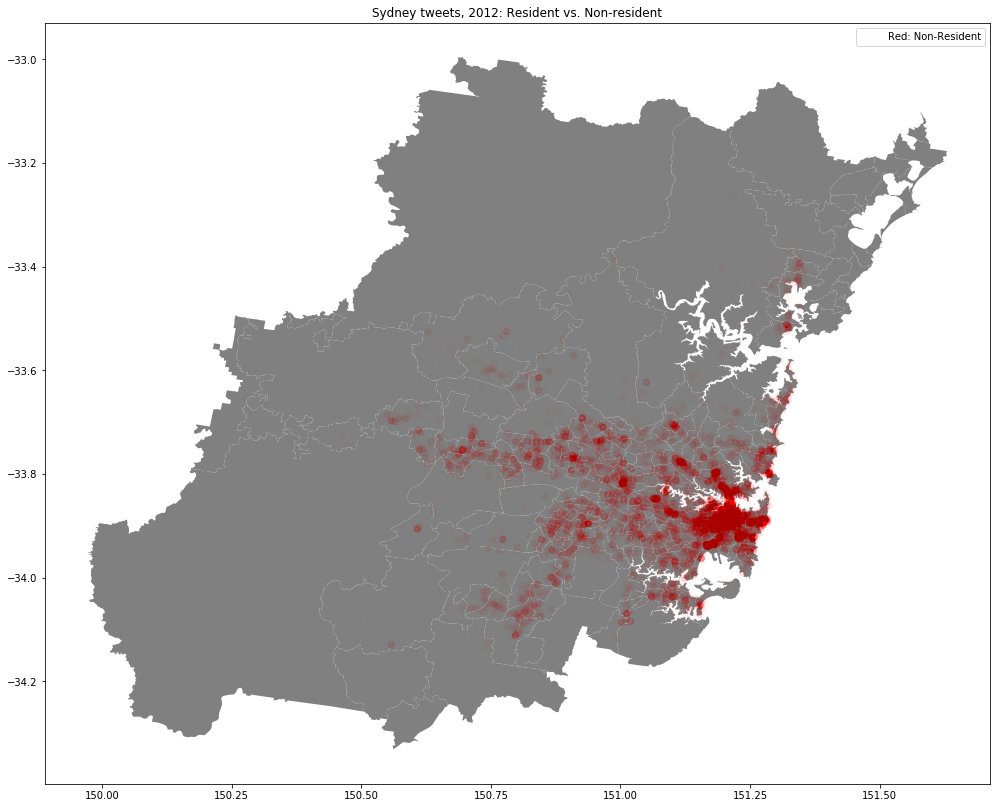

In [129]:
### Plot a 5% sample of 2012 tweets ###
# Blue tweets: Resident
# Red tweets: Non-resident
# Gray: Sydney shapefile

fig, ax = plt.subplots(figsize=(20, 14))

au_shape_sa2['geometry'].plot(ax=ax, color='gray')

sample = autwt_2012[~autwt_2012['SA2_5DIG16'].isnull()].sample(frac=0.05, random_state=42)

sample[~sample['is_home']].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Non-Resident')

sample[sample['is_home']].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Resident')

plt.legend()
plt.title('Sydney tweets, 2012: Resident vs. Non-resident');

In [69]:
print("Original size: ", len(twtsa2_gdf))

Original size:  6178094


In [70]:
homedropped = len(twtsa2_gdf[twtsa2_gdf["home_sa2"].isna()])
print("Number of tracts without home_tract: " ,  homedropped)

Number of tracts without home_tract:  421266


In [73]:
# Create a new dataframe where

tweet_an = twtsa2_gdf[~twtsa2_gdf["home_sa2"].isna()]
tweet_an = twtsa2_gdf[~twtsa2_gdf["SA2_5DIG16"].isna()]
tweet_an = twtsa2_gdf[["date", "SA2_5DIG16" , "home_sa2"]]

In [74]:
print("Final size after dropping nulls: ",len(tweet_an))

Final size after dropping nulls:  6178094


In [ ]:
def stats(arr):
    print("Mean: " , np.mean(arr))
    print("Median: ", np.median(arr))
    print("Std Dev:" , np.std(arr))
    print("Max: " , max(arr))
    print("Min: " , min(arr))

In [80]:
users = twtsa2_gdf.groupby(['u_id','home_sa2']).size().reset_index().rename(columns={0:'count'})

In [81]:
users.head()

,u_id,home_sa2,count
0,718,11337,11
1,1952,11337,25
2,2624,11426,6
3,5177,11291,197
4,5301,11327,198


In [ ]:
# Create a list of derogatory slurs that are used against aboriginal people 
racial_slurs = ['Abo','abo',
 'Abbo','abbo',
 'Boong','boong',
 'Bong','bong',
 'Bung','bung',
 'Coon','coon',
 'Gin','gin',
 'Lubra','lubra']